### Introduction:
Portfolio management is an interesting branch of finance, allowing investors to manage their invested funds through strategies that guarantee expected levels of profitability, corresponding to equivalent levels of risk, without leaving their wealth to chance and speculation.

In this notebook, we will compare the statistical properties of stock prices and returns of a risky asset to conclude which will be more effective for portfolio management. Additionally, we will explore the various portfolio opportunities composed of a number of risky assets by projecting them on a risk-return plane to deduce the optimal positions where a rational investor should place themselves.


Let's start by importing all the Python libraries that we will use in our study.

In [41]:
import yfinance as yf # API pour l'extraction des données de marché
import pandas as pd # Maniplulation des données
import numpy as np # Fonctions mathématiques et Algèbre linéaire 
import matplotlib.pyplot as plt #Visualisation

## I. Statistical Analysis (Prices vs Returns):
Initially, it is essential to import the data on which we will conduct our study. This concerns the daily closing prices of Tesla’s stock throughout the year 2020.

#### 1. Importing the Data:

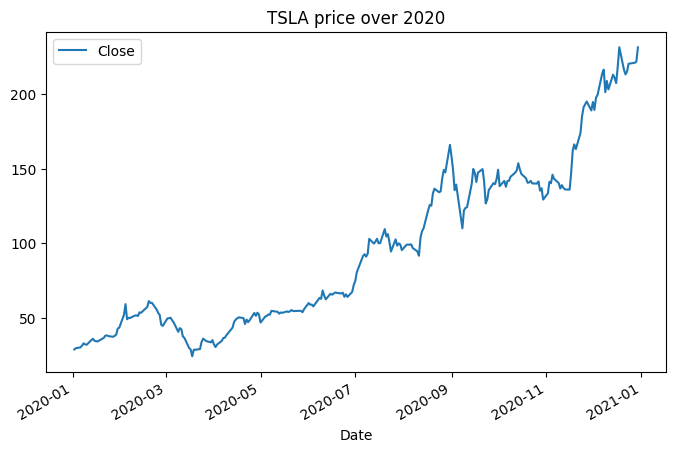

In [42]:
tsla = yf.Ticker("TSLA")
tsla_data = tsla.history(start='2020-01-01', end='2020-12-31')
tsla_df = tsla_data[['Close']]

tsla_df.plot(figsize=(8,5), title='TSLA price over 2020')
plt.show()

#### Daily Log-Returns Series:
This section focuses on creating a column for the asset's daily log-returns by calculating log(St/St-1) for all recorded prices.

C:\Users\pc\AppData\Local\Temp\ipykernel_2904\3923821891.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_df['Return (%)'] = (np.log(1 + tsla_df['Close'].pct_change())*100)


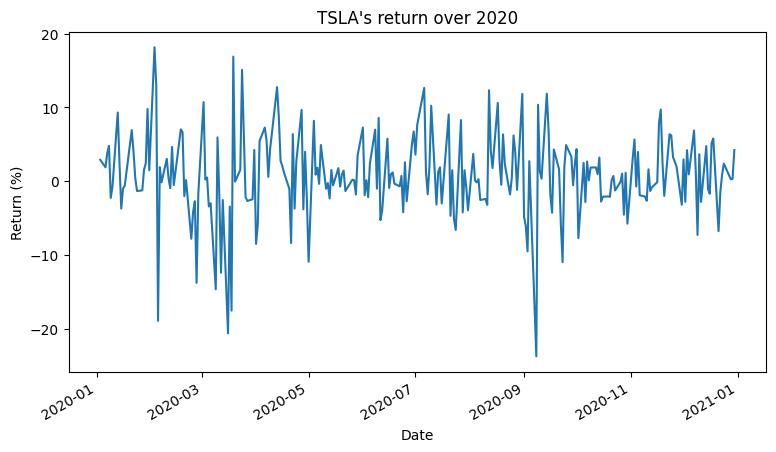

In [43]:
tsla_df['Return (%)'] = (np.log(1 + tsla_df['Close'].pct_change())*100)
tsla_df = tsla_df.iloc[1: , :]

#Plot the returns
tsla_df['Return (%)'].plot(figsize=(9,5), title="TSLA's return over 2020")
plt.ylabel('Return (%)')
plt.show()

#### 2. Extraction of Statistical Properties:
Let us observe the descriptive statistics of the two series: Close Prices (Close) and Returns (%).

In [44]:
tsla_df.describe().round(3)

,Close,Return (%)
count,251.000,251.000
mean,96.385,0.832
std,55.707,5.660
min,24.081,-23.652
25%,49.949,-2.007
50%,80.577,0.743
75%,140.363,3.852
max,231.667,18.145


The data table contains 251 observations of prices and returns during the year 2020. It is observed that the maximum increase in the stock price was 18.145%, and the maximum decrease was -23.653%. However, on average, it yields 0.819% as a daily return.

#### 2.1. Stationarity:
To test the stationarity of the two studied series, we will use the Augmented Dickey-Fuller test.

Here is our custom function that displays the result obtained from the test, as well as the critical values to compare, in order to verify the hypothesis of stationarity.

In [45]:
from statsmodels.tsa.stattools import adfuller
def DFtest(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value','Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [46]:
DFtest(tsla_df['Close'])

Results of Dickey-Fuller Test:
Test Statistic                   0.725376
p-value                          0.990331
Lags Used                        0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


For the 'Close' series, the Augmented Dickey-Fuller (ADF) test statistic is 0.72838, which is below the critical values. However, the p-value is 0.99, which is significantly higher than the 0.05 significance level threshold. Therefore, the null hypothesis of stationarity is rejected.

In [47]:
DFtest(tsla_df['Return (%)'])

Results of Dickey-Fuller Test:
Test Statistic                -1.575188e+01
p-value                        1.220556e-28
Lags Used                      0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


For the Returns series, the Augmented Dickey-Fuller test statistic equals $-15.703$, which is greater than the critical values. Indeed, the p-value is $1.28 \times 10^{-28}$, which is far below the significance level $0.05$. Therefore, we accept the hypothesis of stationarity for the series.

#### 2.2. Autocorrelation:
To check for the existence of autocorrelation in the two series, we will visualize their correlograms, which represent the values of $ \rho_k = Cov(X_t, X_{t-k})$.

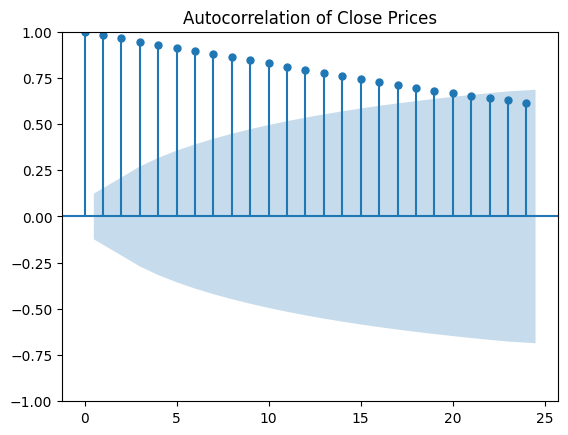

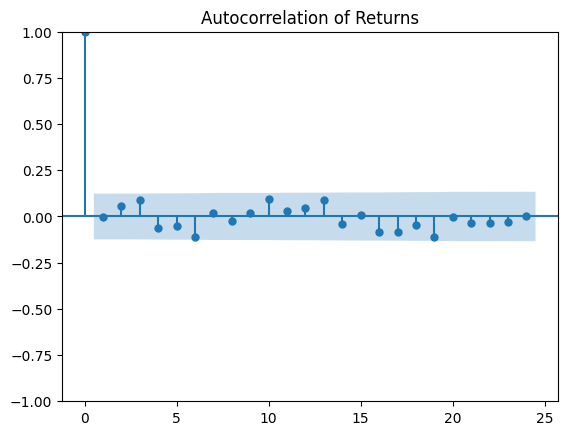

In [48]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(tsla_df['Close'], title='Autocorrelation of Close Prices'),
plot_acf(tsla_df['Return (%)'], title='Autocorrelation of Returns')
plt.show()

For the series of prices (Close), we can observe that the process is autoregressive, meaning that the price at time t depends on its previous values. In this case, it depends on the 21 previous values (the autocorrelations up to lag k=21 are significantly different from 0).

On the other hand, for the series of Returns, we notice that all its autocorrelations are not significantly different from 0. Hence, we can conclude that it is a memoryless process.

#### 2.3. Normality:
To verify the normality of the two time series, we will first visualize their histograms before performing the Shapiro-Wilk test, which is designed for this purpose.

##### • Histograms:

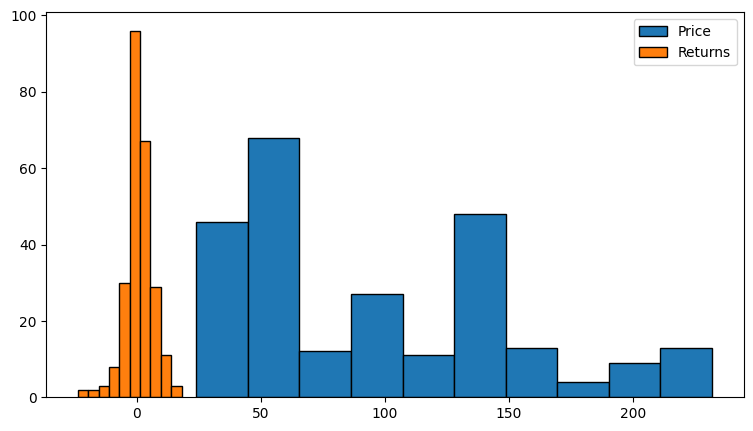

In [49]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.hist(tsla_df['Close'], edgecolor='black', label='Price')
ax.hist(tsla_df['Return (%)'], edgecolor='black', label="Returns")
ax.legend(loc='upper right')
plt.show()

The blue histogram represents the distribution of stock prices. We can observe that it does not resemble a normal distribution at all. In this case, the visualization was sufficient to deduce the non-normality of the prices.

The yellow histogram represents the distribution of Returns. It almost resembles a normal distribution, but it is essential to verify this hypothesis with a normality test.

##### • Normality test (Shapiro-Wilk):

In [50]:
from scipy.stats import shapiro 
shapiro(tsla_df['Close'])

ShapiroResult(statistic=np.float64(0.8994182093383671), pvalue=np.float64(6.650943648833554e-12))

The result of the test shows that the p-value $= 7.569 \times 10^{-12}$ is much lower than the significance level $0.05$. Thus, the null hypothesis of normality is rejected for the price series (i.e., it is highly improbable to obtain such data assuming they are normally distributed).

In [51]:
shapiro(tsla_df['Return (%)'])

ShapiroResult(statistic=np.float64(0.9502228367576668), pvalue=np.float64(1.4609015184472714e-07))

Similarly, the p-value obtained for the Returns series $1.607 \times 10^{-7}$ is much lower than the significance level of 0.05. Thus, the null hypothesis of normality is rejected.

### Conclusion:
The statistical study we conducted in this section allowed us to compare the two series, prices/Returns, and led to the result that the Returns series has statistical properties that will be more effective in portfolio management and forecasting than the price series.

## II. Portfolio Optimization:
We aim to use modern portfolio theory to optimize a portfolio consisting of 4 assets: the stocks of the 4 multinational companies "Tesla, Apple, Netflix, and Amazon."

#### 1. Data Import:
Starting with the import of daily historical prices of these stocks throughout the year 2021. The selection was based on the significant growth that these assets experienced during this period.

[*********************100%***********************]  4 of 4 completed


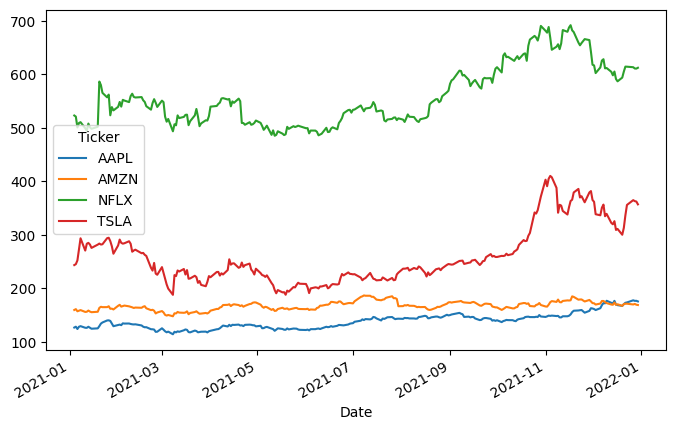

In [52]:
data = yf.download("TSLA AAPL NFLX AMZN", start="2021-01-01", end ="2021-12-31")['Close']
data.plot(figsize=(8,5))
plt.show()

In [53]:
data.head(10)

Ticker,AAPL,AMZN,NFLX,TSLA
Date,,,,
2021-01-04,126.544212,159.331497,522.859985,243.256668
2021-01-05,128.108780,160.925507,520.799988,245.036667
2021-01-06,123.796448,156.919006,500.489990,251.993332
2021-01-07,128.020752,158.108002,508.890015,272.013336
2021-01-08,129.125748,159.134995,510.399994,293.339996
2021-01-11,126.123726,155.710495,499.100006,270.396667
2021-01-12,125.947731,156.041504,494.250000,283.146667
2021-01-13,127.991455,158.294495,507.790009,284.803345
2021-01-14,126.055305,156.373505,500.859985,281.666656


In [54]:
data.describe() 

Ticker,AAPL,AMZN,NFLX,TSLA
count,251.000000,251.000000,251.000000,251.000000
mean,138.201141,167.195247,558.041513,259.630585
std,14.448590,8.018029,56.044233,53.528293
min,113.953247,147.597504,484.980011,187.666672
25%,126.089516,161.664246,512.290009,222.664993
50%,138.633453,167.078995,542.950012,243.256668
75%,146.257240,172.430496,598.889984,283.241653
max,177.423676,186.570496,691.690002,409.970001


As we observed earlier, the object of study will be the Return series of the portfolio, composed of the individual return series of each asset.

We construct these series by calculating the daily log-returns using the formula: $\log\left(\dfrac{S_t}{S_{t-1}}\right)$.

Here are the log-returns for the 4 stocks ('Tesla', 'Apple', 'Netflix', 'Amazon'):

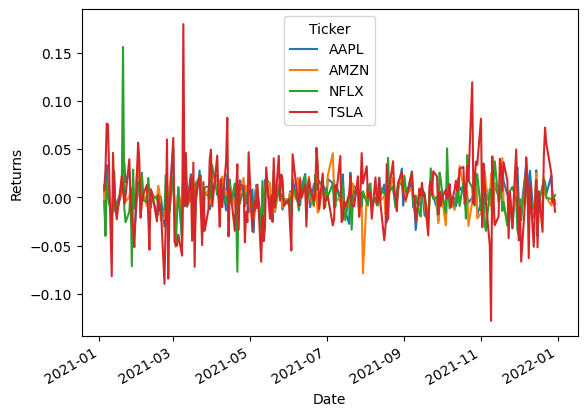

In [55]:
df=np.log(data/data.shift(1))
df.plot()
plt.ylabel('Returns')
plt.show()

In [56]:
df

Ticker,AAPL,AMZN,NFLX,TSLA
Date,,,,
2021-01-04,NaN,NaN,NaN,NaN
2021-01-05,0.012288,0.009955,-0.003948,0.007291
2021-01-06,-0.034241,-0.025212,-0.039778,0.027995
2021-01-07,0.033554,0.007549,0.016644,0.076448
2021-01-08,0.008594,0.006475,0.002963,0.075481
...,...,...,...,...
2021-12-23,0.003637,0.000184,-0.000244,0.056020
2021-12-27,0.022715,-0.008212,-0.001581,0.024935
2021-12-28,-0.005784,0.005827,-0.003938,-0.005013


As we see in the graph above, the Returns of the 4 assets all appear to be stationary. As a result, the Return series of our portfolio will also be stationary regardless of the weights assigned to each asset.

#### 2. Portfolio Return and Risk:
We create a function called `rand_weights` that generates a random weight vector $\pi$, such that: $\pi_i \in [0,1]$ and $∑ \pi_i = 1$.

In [57]:
#Poids aléatoires
def rand_weights(data):
    w = np.random.random(len(data.columns))
    return w/w.sum()

Next, we create the functions `portfolio_return` and `portfolio_std`, which respectively calculate the portfolio's return and volatility based on the assigned weight vector.

In [58]:
def portfolio_return(weights):
    return np.dot(weights, df.sum())

def portfolio_std(weights):
    return np.sqrt((weights.T @ df.cov() * df.count().iloc[0] @ weights))

#### 3. Efficient Frontier:
Next, we will simulate 8000 possible portfolio opportunities to represent their positions on a risk-return plane.

In [59]:
weights_ = []
risks = []
returns = []
for i in range(8000):
    weights = rand_weights(df)
    returns.append(portfolio_return(weights))
    risks.append(portfolio_std(weights))
    weights_.append(weights)

We assign this set of portfolios to a table specifying their Returns, Risks, and the weights of each stock. This step organizes the data for further analysis and visualization, ensuring we can systematically evaluate the performance of generated portfolios.

In [60]:
dict = {}
for c, ticker in enumerate(df.columns.tolist()):
    dict[ticker+' weight'] = [w[c] for w in weights_]
dict["Return"] = returns
dict["Risk"] = risks
portfolios = pd.DataFrame(dict)
portfolios

,AAPL weight,AMZN weight,NFLX weight,TSLA weight,Return,Risk
0,0.351903,0.170797,0.115817,0.361483,0.281144,0.286246
1,0.381559,0.323578,0.080395,0.214469,0.237604,0.243530
2,0.400990,0.434725,0.118951,0.045334,0.191550,0.214811
3,0.397949,0.227208,0.111054,0.263789,0.261195,0.257090
4,0.180452,0.414024,0.221425,0.184100,0.187758,0.234367
...,...,...,...,...,...,...
7995,0.314891,0.133298,0.132275,0.419536,0.291773,0.305532
7996,0.181465,0.211256,0.296646,0.310634,0.236885,0.269458
7997,0.344216,0.395771,0.135529,0.124483,0.203752,0.223607
7998,0.117597,0.137099,0.401473,0.343831,0.241079,0.285340


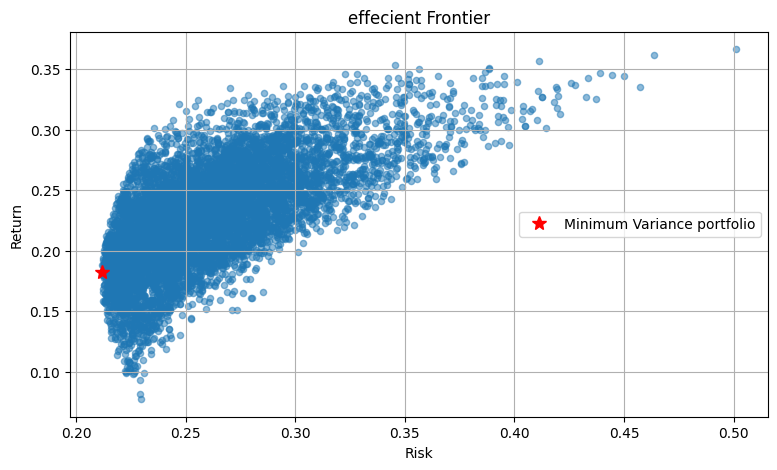

In [61]:
portfolios.plot.scatter("Risk", "Return", marker='o', grid=True, alpha=0.5, title='effecient Frontier', figsize=(9,5))
plt.plot(min(risks), returns[risks.index(min(risks))], '*', markersize=10, c='r', label="Minimum Variance portfolio")
plt.legend(loc='right')
plt.show()

The representation of the different portfolio combinations forms a scatterplot that is convex in relation to risk. All optimal portfolios belong to the efficient frontier at the top, starting from the Minimum-Variance portfolio (represented by the red star).

#### 4. Performance Measurement:

Performance measurements are based on the CAPM model.
Let us assume an explanatory model of returns as a function of market risk (CAPM). We distinguish 3 classic measures:

• The Sharpe Ratio

• The Treynor Ratio

• Jensen’s Alpha

The two ratios measure the portfolio's excess return relative to the risk-free rate.
The Jensen and Treynor measures rely on the systematic risk of the portfolio obtained from the Security Market Line (SML).
The Sharpe ratio refers to the total risk of the portfolio.

The representation of the different combinations of the portfolio forms a scatterplot that is convex in relation to risk. All optimal portfolios belong to the efficient frontier at the top, starting from the Minimum-Variance portfolio (represented by the red star).

##### a. Sharpe Ratio:
It is based on the Capital Market Line (CML):  $E(R_p) = r_f + \dfrac{\sigma(R_p)}{\sigma(R_M)}(E(R_M) - r_f)$

All efficient portfolios should lie on this line.
The Sharpe ratio is defined as:  $SR = \dfrac{E(R_p) - r_f}{\sigma(R_p)}$

Where $R_p$ is the return of the portfolio, $r_f$ is the risk-free rate, and $\sigma(R_p)$ is the total risk of the portfolio.
$SR$ measures the excess return per unit of total risk.

The higher the ratio, the more efficient the portfolio.

In [62]:
Rf = 0.02 #Return sans risque

sharpe_ratio = (portfolios['Return'] - Rf) / portfolios['Risk']

slope = max(sharpe_ratio)
x = np.linspace(0,0.5,50) 
y = Rf + slope*x #Droite CML

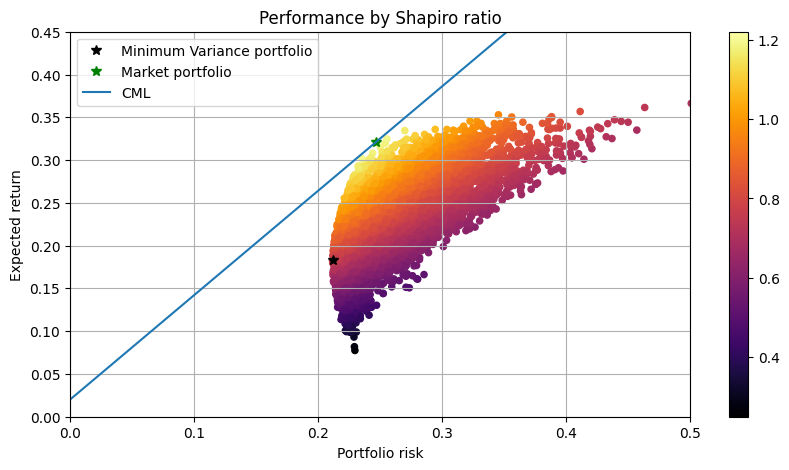

In [63]:
#Visualisation
portfolios.plot.scatter("Risk", "Return", marker='o', grid=True, c=sharpe_ratio, cmap='inferno', title='Performance by Shapiro ratio', figsize=(10,5))
plt.plot(min(risks), returns[risks.index(min(risks))], '*', markersize=7, c='k', label="Minimum Variance portfolio")
plt.plot(risks[sharpe_ratio.idxmax()], returns[sharpe_ratio.idxmax()], '*', markersize=7, c='g', label="Market portfolio")
plt.xlabel('Portfolio risk')
plt.ylabel('Expected return')
plt.plot(x,y, label='CML')
plt.ylim(ymin=0, ymax=0.45)
plt.xlim(xmin=0, xmax=0.5)
plt.legend()
plt.show()

The coloring of the portfolio cloud based on the Sharpe ratio shows that the closer one moves upwards toward the CML, the more efficient the portfolios become. Indeed, the CML is tangent to this cloud at the most efficient portfolio, which has the maximum Sharpe ratio (Market Portfolio).

##### b. Treynor Ratio:
The Treynor ratio measures the excess return adjusted for systematic risk. It is expressed as: $RT=\dfrac{E(R_p)-r_f}{\beta_p}$

The higher the ratio, the more efficient the portfolio.

We will use the S&P500 index as the benchmark for our portfolio of stocks.

[*********************100%***********************]  1 of 1 completed


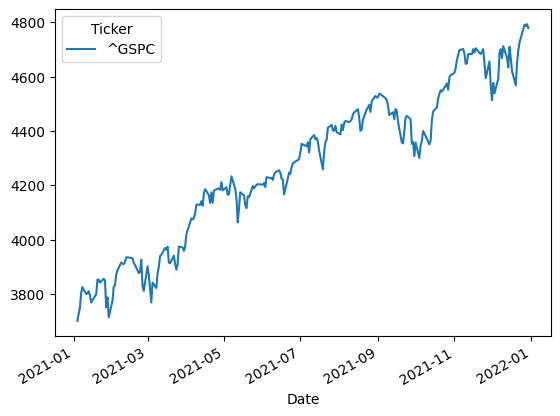

In [64]:
#Extraction des cours de l'indice
sp = yf.download('^GSPC', start="2021-01-01", end ="2021-12-31")['Close'] 
sp.plot()
plt.show()

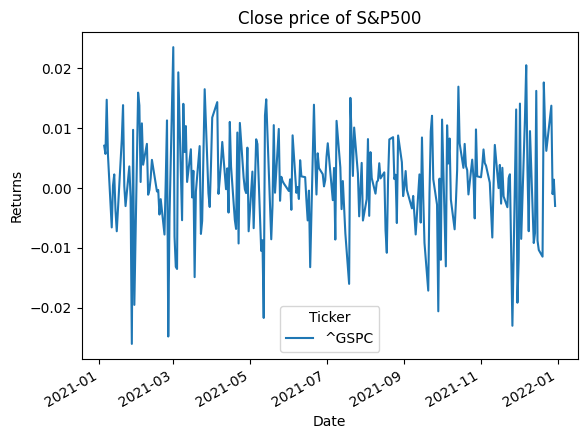

In [65]:
#Returns de l'indice sur 2021
sp=np.log(sp/sp.shift(1))
sp.plot(title="Close price of S&P500")
plt.ylabel('Returns')
plt.show()

In [66]:
df1 = df.loc[:]
df1 = df1.reset_index(drop=True)
sp = sp.reset_index(drop=True)
df1['S&P500']=sp
df1=df1[1:]
df1.head()

Ticker,AAPL,AMZN,NFLX,TSLA,S&P500
1,0.012288,0.009955,-0.003948,0.007291,0.007058
2,-0.034241,-0.025212,-0.039778,0.027995,0.005694
3,0.033554,0.007549,0.016644,0.076448,0.014738
4,0.008594,0.006475,0.002963,0.075481,0.005477
5,-0.023523,-0.021754,-0.022388,-0.081442,-0.006576


We begin by calculating the individual sensitivities, $\beta_i$, of the stocks to the benchmark using the formula:
$$\beta_i=\frac{Cov(R_i, R_M)}{\sigma^2(R_M)}$$

Here:
- $R_i$ is the return of the stock $i$.
- $R_M$ is the return of the market (benchmark, e.g., S&P500).
- $Cov(R_i, R_M)$ represents the covariance between the stock's return and the market return, which measures how much the stock's return moves relative to the market return.
- $\sigma^2(R_M)$ is the variance of the market return, which represents the overall market risk.

In the context of portfolio management, $\beta_i$ reflects the systematic risk of a stock, i.e., its sensitivity to fluctuations in the overall market. A higher beta implies that the stock is more volatile relative to the market, while a lower beta indicates lesser sensitivity. This measure is crucial for assessing risk-adjusted returns and is a key input in performance metrics like the Treynor Ratio and Jensen's Alpha.

In [67]:
def calc_beta(df):
    s = df.values
    # Benchmark is the fifth column (4)
    beta = []
    for i, col in enumerate(df):
        if i < 4:
            # Calculate covariance matrix between each stock i and the benchmark
            covariance = np.cov(s[:,i] ,s[:,4] ) 
            beta.append( covariance[0,1]/covariance[1,1] )
    return pd.Series(beta, df.columns[:-1], name='Beta')

beta = calc_beta(df1)
beta

Ticker
AAPL    1.308005
AMZN    1.041425
NFLX    0.991385
TSLA    1.924928
Name: Beta, dtype: float64

To obtain the beta of each portfolio, it is sufficient to calculate the sum of the weightings of the betas of the stocks.

In [68]:
portfolios['Portfolio Beta'] = np.dot(beta, portfolios.values[:,:-2].T)
portfolios

,AAPL weight,AMZN weight,NFLX weight,TSLA weight,Return,Risk,Portfolio Beta
0,0.351903,0.170797,0.115817,0.361483,0.281144,0.286246,1.448811
1,0.381559,0.323578,0.080395,0.214469,0.237604,0.243530,1.328602
2,0.400990,0.434725,0.118951,0.045334,0.191550,0.214811,1.182422
3,0.397949,0.227208,0.111054,0.263789,0.261195,0.257090,1.375012
4,0.180452,0.414024,0.221425,0.184100,0.187758,0.234367,1.241102
...,...,...,...,...,...,...,...
7995,0.314891,0.133298,0.132275,0.419536,0.291773,0.305532,1.489411
7996,0.181465,0.211256,0.296646,0.310634,0.236885,0.269458,1.349401
7997,0.344216,0.395771,0.135529,0.124483,0.203752,0.223607,1.236385
7998,0.117597,0.137099,0.401473,0.343831,0.241079,0.285340,1.356460


Afterwards, we calculate Treynor ratio

In [69]:
#Treynor ratio
RT = (portfolios['Return'] - Rf) / portfolios['Portfolio Beta']
RT

0       0.180247
1       0.163784
2       0.145084
3       0.175413
4       0.135168
          ...   
7995    0.182470
7996    0.160727
7997    0.148620
7998    0.162982
7999    0.160619
Length: 8000, dtype: float64

In [70]:
cml = Rf+(sp.sum()-Rf)*portfolios['Portfolio Beta']

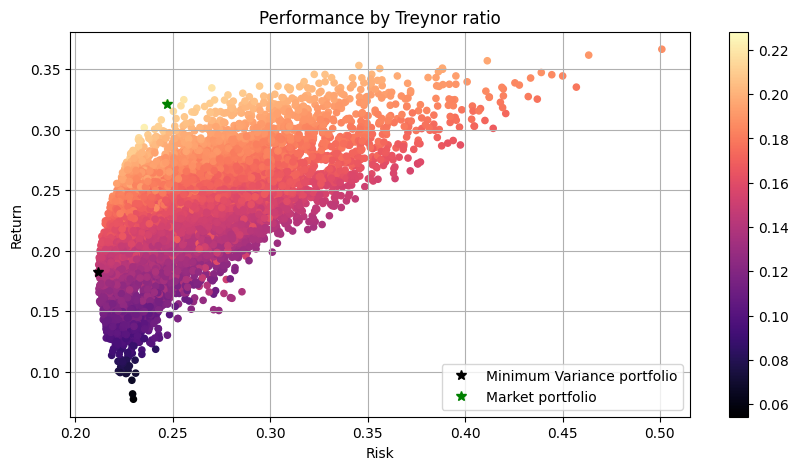

In [71]:
#Visualisation
portfolios.plot.scatter("Risk", "Return", marker='o', grid=True, c=RT, cmap='magma', title='Performance by Treynor ratio', figsize=(10,5))
plt.plot(min(risks), returns[risks.index(min(risks))], '*', markersize=7, c='k', label="Minimum Variance portfolio")
plt.plot(risks[RT.idxmax()], returns[RT.idxmax()], '*', markersize=7, c='g', label="Market portfolio")
plt.legend()
plt.show()

As previously, the coloring of the portfolio cloud according to the Treynor ratio indicates that the higher you go toward the market portfolio, the more efficient the portfolios become.

##### c. Jensen's Alpha:
Measures the performance not explained by the CAPM. The portfolio's excess return compared to the theoretical, risk-adjusted return. It is written as: $\alpha_p=E(R_p)-[r_f+\beta_p(E(R_M)-r_f)]$
###### CAPM Prediction:

In [72]:
def medaf(pf):
    df1 = pf.loc[:]
    df1['MEDAF Return'] = Rf+(sp.sum()-Rf)*pf['Portfolio Beta']
    return df1

b=medaf(portfolios)

In [73]:
def alpha(pf):
    df1 = pf.loc[:]
    df1['Portfolio Alpha'] = pf['Return'] - pf['MEDAF Return']
    return df1

c = alpha(b)
#max(alpha(b)['Portfolio Alpha'])
alpha= c['Portfolio Alpha']
c

,AAPL weight,AMZN weight,NFLX weight,TSLA weight,Return,Risk,Portfolio Beta,MEDAF Return,Portfolio Alpha
0,0.351903,0.170797,0.115817,0.361483,0.281144,0.286246,1.448811,NaN,NaN
1,0.381559,0.323578,0.080395,0.214469,0.237604,0.243530,1.328602,NaN,NaN
2,0.400990,0.434725,0.118951,0.045334,0.191550,0.214811,1.182422,NaN,NaN
3,0.397949,0.227208,0.111054,0.263789,0.261195,0.257090,1.375012,NaN,NaN
4,0.180452,0.414024,0.221425,0.184100,0.187758,0.234367,1.241102,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7995,0.314891,0.133298,0.132275,0.419536,0.291773,0.305532,1.489411,NaN,NaN
7996,0.181465,0.211256,0.296646,0.310634,0.236885,0.269458,1.349401,NaN,NaN
7997,0.344216,0.395771,0.135529,0.124483,0.203752,0.223607,1.236385,NaN,NaN
7998,0.117597,0.137099,0.401473,0.343831,0.241079,0.285340,1.356460,NaN,NaN


The last column above presents the alpha of each portfolio.

We observe that all the portfolios have negative alphas, indicating that the selected securities are underperforming compared to the benchmark index.

### Conclusion:

In this notebook, we started by comparing the statistical properties of the series of stock prices and returns to deduce which one is more useful in portfolio management.

Then, we focused on optimizing a portfolio consisting of 4 stocks by simulating 8000 different combinations of these securities, to plot the efficient frontier where a rational investor should be located.

Finally, we concluded the work by measuring their performances according to the famous metrics: Sharpe, Treynor, and Jensen.